# TP: Application des RNN (Réseaux de Neurones Récurrents) pour la prédiction de trajectoire,
L'objectif est de modéliser et prédire la trajectoire d'une coccinelle en utilisant un Réseau de Neurones Récurrent (RNN), un type de modèle de Deep Learning conçu pour les données séquentielles.

Nous allons :

1. Générer une trajectoire virtuelle de la coccinelle 🐞.
2. Visualiser cette trajectoire.
3. Préparer les données sous forme de séquences temporelles.
4. Construire un RNN (LSTM ou GRU) pour prédire la trajectoire future.
5. Entraîner le modèle et évaluer ses performances.
6. Faire des prédictions et comparer avec la trajectoire réelle.

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import random

## Étape 1 - Définition des paramètres
📌 Consigne : Définition des paramètres pour la génération du dataset et l'entraînement du modèle.

In [25]:
# ---- Paramètres du dataset ----
max_t = 1000        # Durée maximale pour la génération de la trajectoire
delta_t = 0.01      # Intervalle de temps entre chaque point généré
features_len = 2    # Nombre de dimensions (X, Y)

sequence_len = 20   # Nombre de pas de temps utilisés pour les séquences d'entrée
predict_len = 5     # Nombre de pas de temps à prédire

# ---- Paramètres d'entraînement ----
scale = 0.2         # Pourcentage des données utilisées (1 = toutes les données)
train_prop = 0.8    # Pourcentage des données utilisées pour l'entraînement
batch_size = 32     # Nombre d'échantillons par batch
epochs = 5          # Nombre d'époques d'entraînement
fit_verbosity = 1   # Niveau de détails d'affichage (0 = silence, 1 = barre de progression, 2 = une ligne par époque)

# Affichage des paramètres définis
print(f"max_t = {max_t}, delta_t = {delta_t}, features_len = {features_len}")
print(f"sequence_len = {sequence_len}, predict_len = {predict_len}")
print(f"scale = {scale}, train_prop = {train_prop}, batch_size = {batch_size}, epochs = {epochs}, fit_verbosity = {fit_verbosity}")


max_t = 1000, delta_t = 0.01, features_len = 2
sequence_len = 20, predict_len = 5
scale = 0.2, train_prop = 0.8, batch_size = 32, epochs = 5, fit_verbosity = 1


## Étape 2 - Génération de la trajectoire virtuelle de la coccinelle
📌 Consigne : Implémentation des fonctions pour la génération de la trajectoire pseudo-aléatoire d'une coccinelle.

In [27]:
def ladybug_init(s=122):
    """
    Initialise les paramètres aléatoires pour la génération de la trajectoire de la coccinelle.
    
    - s : Seed pour la reproductibilité.
    """
    if s > 0:
        random.seed(s)
    
    # Génération de 8 paramètres aléatoires pour X et Y
    ladybug_init.params_x = [random.gauss(0., 1.) for _ in range(8)]
    ladybug_init.params_y = [random.gauss(0., 1.) for _ in range(8)]

def ladybug_move(t):
    """
    Génère une position (x, y) pour un instant t donné en combinant des sinus et cosinus.

    - t : Temps auquel la position doit être calculée.
    
    Retourne :
    - x, y : Coordonnées de la coccinelle à l'instant t.
    """
    # Récupération des paramètres aléatoires pour X et Y
    [ax1, ax2, ax3, ax4, kx1, kx2, kx3, kx4] = ladybug_init.params_x
    [ay1, ay2, ay3, ay4, ky1, ky2, ky3, ky4] = ladybug_init.params_y

    # Calcul des positions X et Y avec des oscillations sinusoïdales
    x = (ax1 * np.sin(t * (kx1 + 20)) + ax2 * np.cos(t * (kx2 + 10)) + 
         ax3 * np.sin(t * (kx3 + 5)) + ax4 * np.cos(t * (kx4 + 5)))

    y = (ay1 * np.cos(t * (ky1 + 20)) + ay2 * np.sin(t * (ky2 + 10)) + 
         ay3 * np.cos(t * (ky3 + 5)) + ay4 * np.sin(t * (ky4 + 5)))

    return x, y

# Vérification de la fonction en générant un point pour t = 1.0
ladybug_init()  # Initialisation des paramètres
x_test, y_test = ladybug_move(1.0)
print(f"Exemple de position générée : x = {x_test:.4f}, y = {y_test:.4f}")


Exemple de position générée : x = 0.5113, y = -0.2353


## Étape 3- Récupération des positions et normalisation des données
📌 Consigne :

1. Générer des positions de la coccinelle en fonction du temps.
2. Redimensionner les données selon un certain pourcentage (scale).
3. Diviser les données en train/test avec train_prop = 0.8.
4. Normaliser les données pour améliorer la convergence du modèle.

In [29]:

# ---- Générer les positions ----
ladybug_init(s=16)  # Initialisation avec une seed pour reproductibilité
x, y = 0, 0
positions = []

# Génération des positions de la coccinelle pour max_t avec un pas delta_t
for t in np.arange(0., max_t, delta_t):
    x, y = ladybug_move(t)
    positions.append([x, y])

# ---- Redimensionner le dataset ----
n = int(len(positions) * scale)  # Prendre un sous-ensemble des données
dataset = np.array(positions[:n])  # Transformer en numpy array

# Séparer en train/test
k = int(len(dataset) * train_prop)  # Nombre d'échantillons pour le train
x_train = dataset[:k]
x_test = dataset[k:]

# ---- Normalisation ----
mean = x_train.mean(axis=0)  # Moyenne par dimension (X et Y)
std = x_train.std(axis=0)    # Écart-type par dimension (X et Y)

x_train = (x_train - mean) / std  # Normalisation des données d'entraînement
x_test = (x_test - mean) / std    # Normalisation des données de test

# Affichage des résultats
print("Dataset generated.")
print("Train shape is :", x_train.shape)
print("Test shape is  :", x_test.shape)

Dataset generated.
Train shape is : (16000, 2)
Test shape is  : (4000, 2)


## Étape 4 - Visualisation de la trajectoire générée
📌 Consigne :

1. Tracer la trajectoire de la coccinelle à partir des données d'entraînement x_train.
2. Mettre en évidence les segments de la trajectoire avec des couleurs différentes.

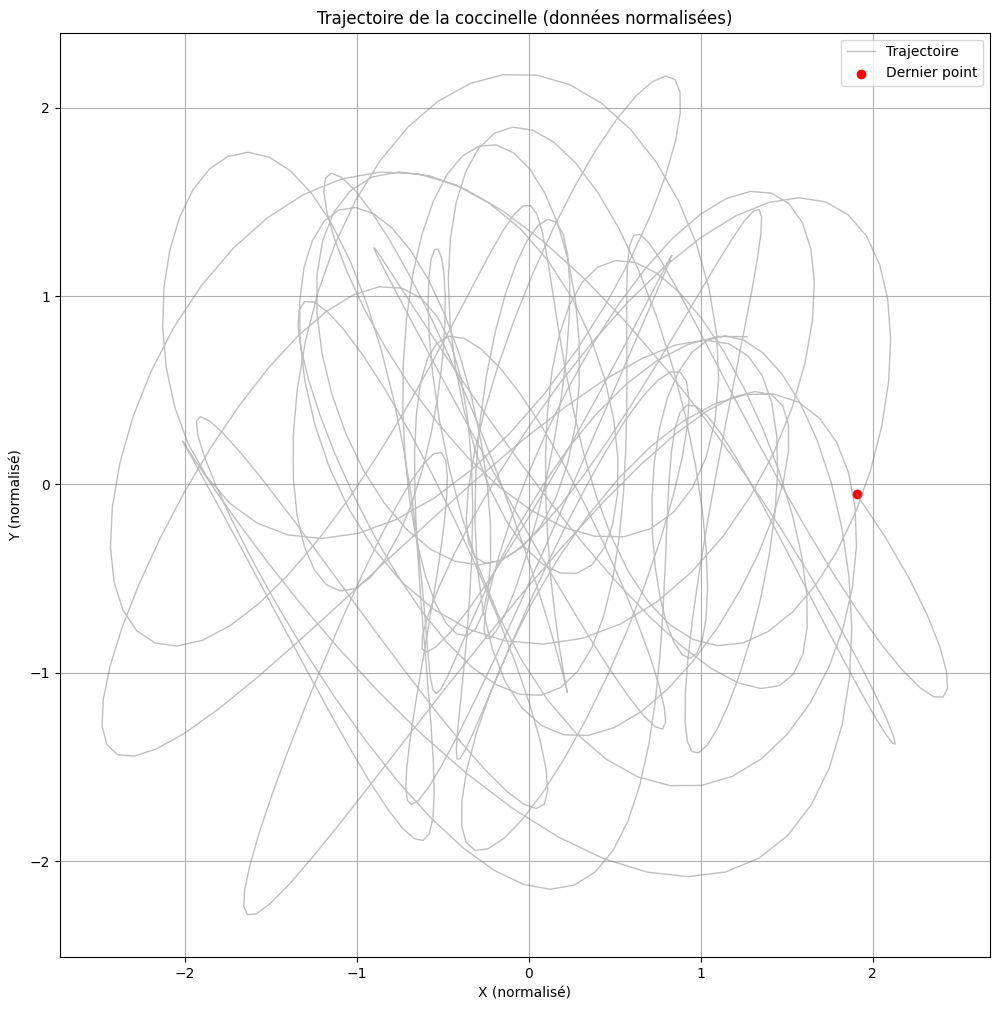

# Étape 5 - Visualisation d'un segment de la trajectoire
📌 Consigne :

1. Sélectionner un segment aléatoire de la trajectoire dans x_test.
2. Afficher les points de la séquence d'entrée (en bleu) et les points à prédire (en rouge).

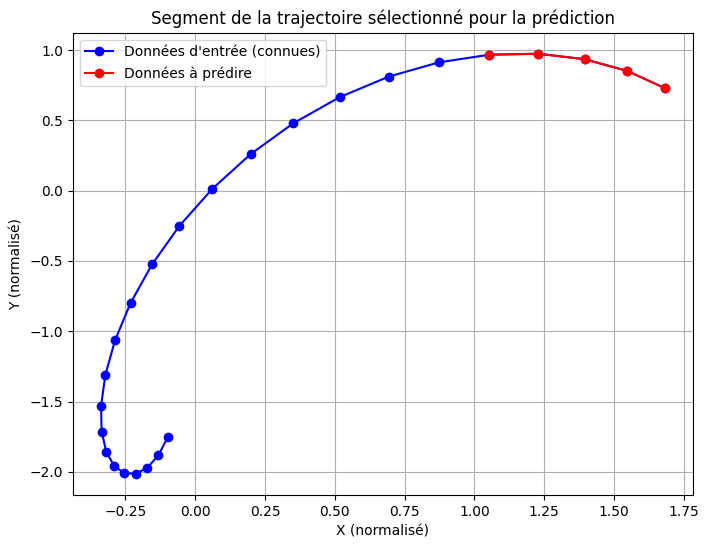

In [33]:

# Sélection aléatoire d'un segment dans le jeu de test


# Séparation des points connus et des points à prédire


# Affichage du segment sélectionné


 ## Étape 6 Préparation des séquences pour l'entraînement du modèle
📌 Consigne :

1. Transformer x_train et x_test en séquences temporelles pour le modèle LSTM.
2. Chaque séquence d'entrée contient sequence_len (20) pas de temps et la sortie est la position suivante.
3. Conversion en float16 pour réduire la mémoire utilisée.

In [35]:


# ---- Création des séquences et labels pour l'entraînement ----


# ---- Création des séquences et labels pour le test ----


# ---- Conversion en numpy arrays en `float16` pour optimiser la mémoire ----


# ---- Affichage des résultats ----


# ---- Exemple d'une séquence d'entrée et de sortie ----




📌 About the splitting of our dataset :
Number of sequences : 15979
xs_train shape      : (15979, 20, 2)
ys_train shape      : (15979, 2)

📌 Example of an xs (input sequence) :
[[ 1.595     0.3066  ]
 [ 1.505     0.5015  ]
 [ 1.394     0.6675  ]
 [ 1.264     0.797   ]
 [ 1.119     0.8853  ]
 [ 0.9644    0.9277  ]
 [ 0.8037    0.923   ]
 [ 0.6416    0.8706  ]
 [ 0.4832    0.7725  ]
 [ 0.3333    0.632   ]
 [ 0.1962    0.4539  ]
 [ 0.0763    0.2454  ]
 [-0.02283   0.013916]
 [-0.09814  -0.2317  ]
 [-0.1473   -0.4822  ]
 [-0.1691   -0.728   ]
 [-0.1627   -0.96    ]
 [-0.1287   -1.169   ]
 [-0.068    -1.348   ]
 [ 0.01706  -1.489   ]]

📌 Example of an ys (output label) :
[ 0.12366 -1.589  ]


## Étape 7 Création du modèle GRU
📌 Consigne :

1. Construire un modèle RNN basé sur GRU pour la prédiction de trajectoire.
2. Utiliser une couche GRU avec 200 unités et une activation ReLU.
3. Ajouter une couche Dense pour la sortie (X, Y).
4. Compiler le modèle avec l'optimiseur rmsprop et la fonction de perte MSE (Mean Squared Error).

In [37]:


# ---- Définition du modèle ----


# ---- Résumé du modèle ----


# ---- Compilation du modèle ----



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 200)            │       122,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           402 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,802 (479.70 KB)

 Trainable params: 122,802 (479.70 KB)

 Non-trainable params: 0 (0.00 B)

## Étape 8 - Entraînement du modèle GRU
📌 Consigne :

1. Ajouter un callback pour enregistrer le meilleur modèle pendant l'entraînement.
2. Entraîner le modèle sur les données de séquences (xs_train, ys_train).
3. Utiliser 10 epochs et valider sur xs_test, ys_test.
4. Suivre la progression de l'entraînement avec verbose=fit_verbosity.

In [39]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# ---- Création du dossier pour enregistrer le modèle ----


# ---- Callback pour sauvegarder le meilleur modèle ----


# ---- Entraînement du modèle ----


Epoch 1/5
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0904 - mae: 0.1874
Epoch 1: val_mae improved from inf to 0.06827, saving model to models/best_model.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.0901 - mae: 0.1871 - val_loss: 0.0083 - val_mae: 0.0683
Epoch 2/5
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0030 - mae: 0.0435
Epoch 2: val_mae improved from 0.06827 to 0.05470, saving model to models/best_model.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.0030 - mae: 0.0435 - val_loss: 0.0051 - val_mae: 0.0547
Epoch 3/5
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0017 - mae: 0.0320
Epoch 3: val_mae improved from 0.05470 to 0.04017, saving model to models/best_model.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - loss: 0.0017 - mae: 0.0320 - val_loss: 0.0031 - val_mae: 0.0402
Epoch 4/5
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0011 - mae: 0.0266
Epoch 4: val_mae did not improve from 0.04017
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 2

## Étape 9 - Visualisation des performances de l'entraînement
📌 Consigne :

1. Tracer l'évolution des pertes (loss et val_loss) au fil des époques.
2. Tracer l'évolution de l'erreur absolue moyenne (mae et val_mae).
3. Vérifier si le modèle converge bien et détecter un éventuel sur-apprentissage.

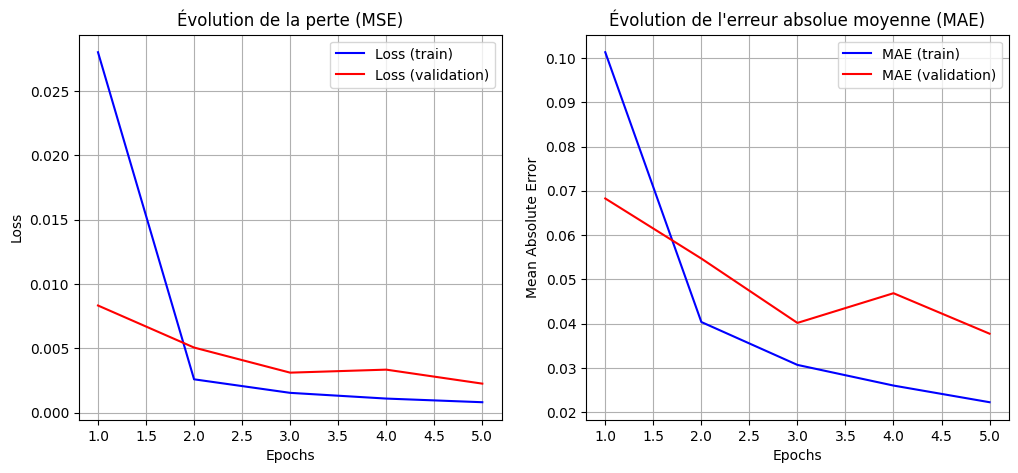

In [42]:
# ---- Récupération des métriques ----


# ---- Tracé de la courbe de perte ----


# ---- Tracé de la courbe de MAE ----


## Étape 10 - Prédiction avec le modèle GRU
📌 Consigne :

1. Charger le meilleur modèle sauvegardé.
2. Effectuer une prédiction à 1 pas de temps sur un échantillon aléatoire.
3. Comparer la vraie trajectoire et la prédiction.

In [44]:
from tensorflow.keras.models import load_model


✅ Modèle chargé avec succès.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
📌 Shapes :
sequence shape      : (20, 2)
sequence true shape : (21, 2)
sequence pred shape : (1, 2)


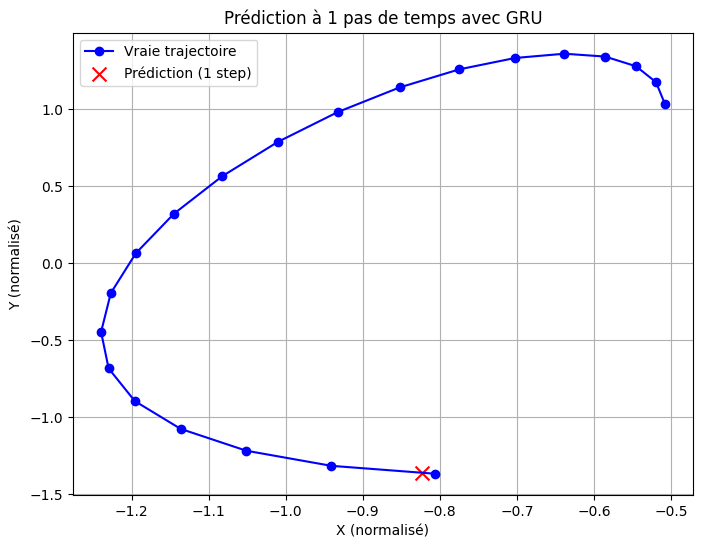

In [46]:

# ---- Sélection d'un échantillon aléatoire dans les données de test ----




# ---- Prédiction du point suivant ----


# ---- Affichage des formes des données ----


# ---- Visualisation ----


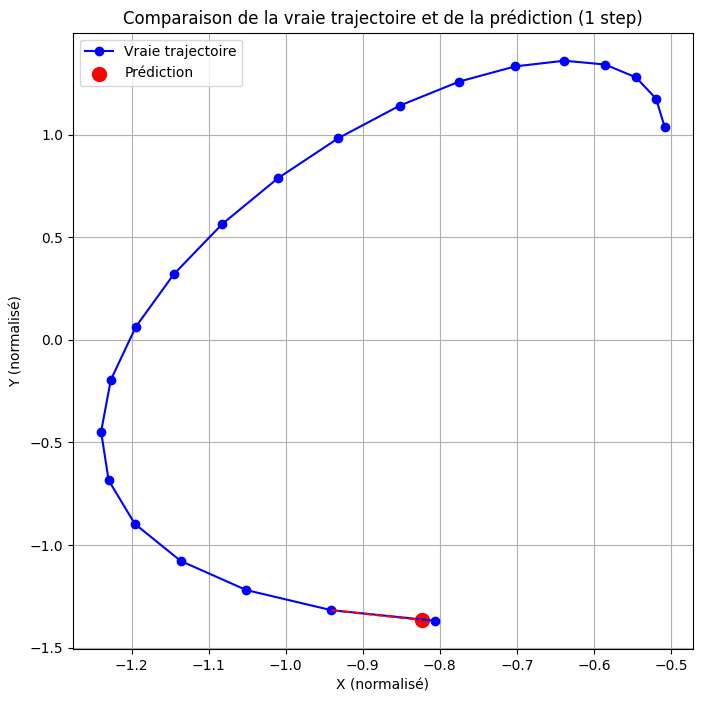

## Étape 11 - Prédiction à plusieurs pas de temps (n-steps)
📌 Objectif :

1. Faire une prédiction sur plusieurs pas de temps (itérative).
2. À chaque itération, le modèle prédit le prochain point, puis réutilise cette prédiction comme entrée pour la suivante.
3. Comparer la trajectoire réelle et la prédiction sur plusieurs étapes.

In [50]:

def get_prediction(dataset, model, iterations=5):
    """
    Génère une prédiction à plusieurs pas de temps en itérant sur le modèle.

    - dataset : Données de test normalisées
    - model : Modèle LSTM/GRU entraîné
    - iterations : Nombre de pas de prédiction

    Retourne :
    - sequence_true : La vraie trajectoire sur les prochains pas
    - sequence_pred : La trajectoire prédite par le modèle
    """
   

    return sequence_true, sequence_pred


C:\Users\nessr\AppData\Local\Temp\ipykernel_44812\2052730732.py:13: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(sequence_pred[:, 0], sequence_pred[:, 1], 'o-', color="red", linestyle="dashed", label="Trajectoire prédite")


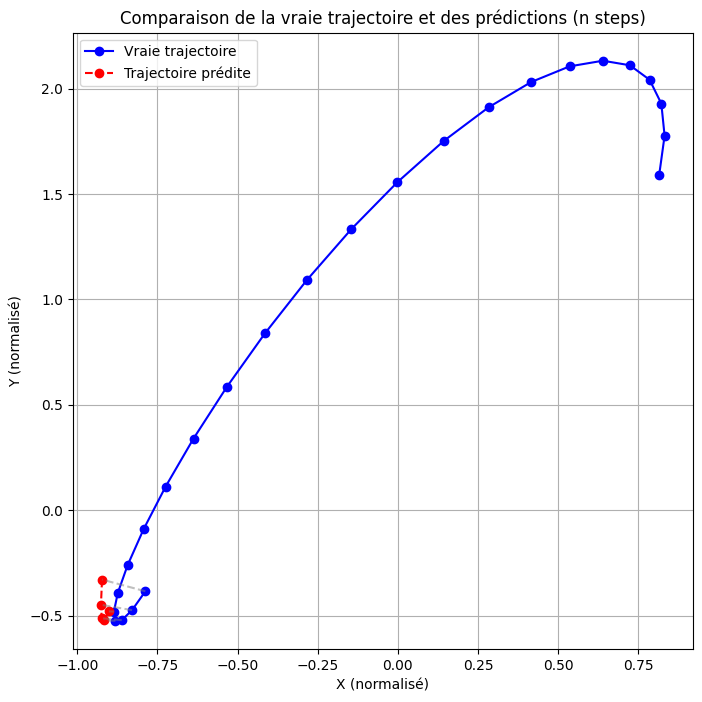

In [52]:
# ---- Faire une prédiction sur 5 pas de temps ----

# ---- Affichage des résultats ----


C:\Users\nessr\AppData\Local\Temp\ipykernel_44812\2759068977.py:8: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(sequence_pred[:, 0], sequence_pred[:, 1], 'o-', color="red", linestyle="dashed", label="Trajectoire prédite")
C:\Users\nessr\AppData\Local\Temp\ipykernel_44812\2759068977.py:18: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(sequence_pred[:, 0], [0] * len(sequence_pred), 'o-', color="red", alpha=0.5, linestyle="dashed")
C:\Users\nessr\AppData\Local\Temp\ipykernel_44812\2759068977.py:22: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot([0] * len(sequence_pred), sequence_pred[:, 1], 'o-

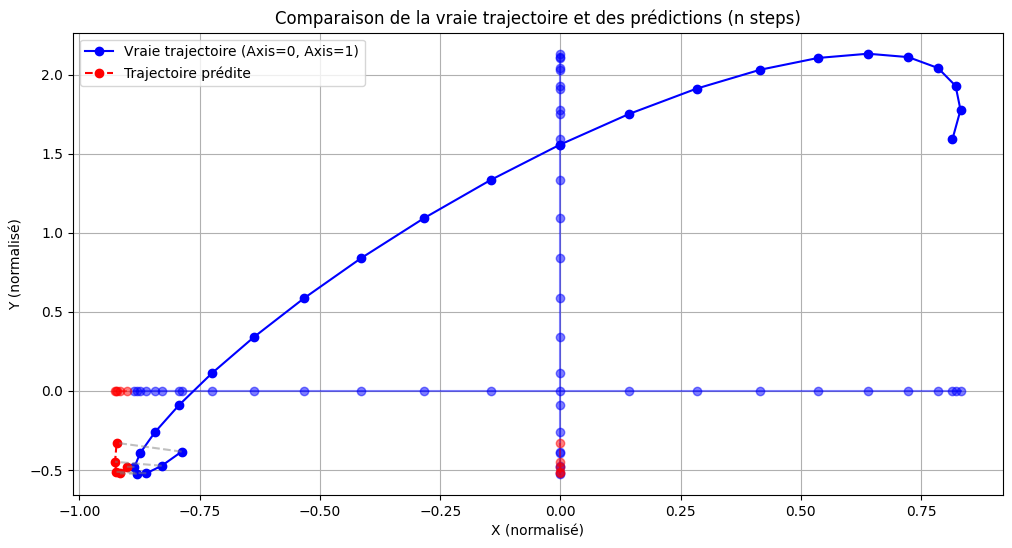

C:\Users\nessr\AppData\Local\Temp\ipykernel_44812\2227709394.py:6: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  axes[0].plot(range(sequence_len, sequence_len + len(sequence_pred)), sequence_pred[:, 0], 'o-', color="red", linestyle="dashed", label="Prédiction X")
C:\Users\nessr\AppData\Local\Temp\ipykernel_44812\2227709394.py:15: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  axes[1].plot(range(sequence_len, sequence_len + len(sequence_pred)), sequence_pred[:, 1], 'o-', color="red", linestyle="dashed", label="Prédiction Y")


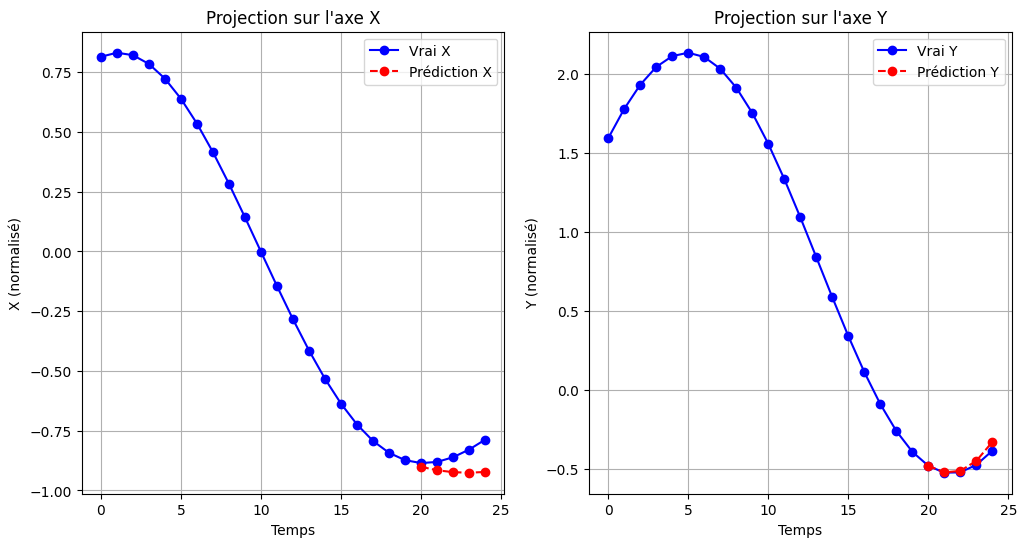